## Problem Definition — Spam Email Detection

### Objective:
Develop a machine learning model to automatically classify messages as **Spam** or **Ham (Not Spam)** based on their textual content.

### Problem Statement:
Spam messages are unwanted, promotional, or potentially malicious communications that negatively impact user experience and security. The goal of this project is to build a robust binary classification model that can accurately detect spam messages while minimizing false positives.

### Dataset:
The dataset contains labeled messages:
- **Ham (0)** — legitimate messages
- **Spam (1)** — unwanted or promotional messages

### Approach:
- Perform Exploratory Data Analysis (EDA)
- Clean and preprocess text data (lowercasing, punctuation removal, stopwords removal, stemming)
- Engineer additional statistical features (message length, digit count, exclamation count)
- Convert text into numerical features using **TF-IDF Vectorization**
- Train a **Multinomial Naive Bayes** classifier
- Apply hyperparameter tuning using GridSearchCV
- Evaluate using Precision, Recall, F1-score, Accuracy
- Validate generalization using Cross-Validation
- Save the final pipeline for reuse

### Expected Outcome:
A reliable spam detection model with high precision and recall, capable of generalizing well to unseen data without overfitting.

##  Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import joblib

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##  Load Dataset

#### Data Loading

In this step, we load the spam dataset and prepare the main columns.

- Select only the relevant columns (label and message)
- Rename columns for clarity
- Convert labels (ham/spam) into numeric values (0/1)

In [4]:
df = pd.read_csv("spam.csv", encoding="latin-1")
df = df[['v1', 'v2']]   
df.columns = ['label', 'message']  
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


##  Dataset Overview

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df["label"].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

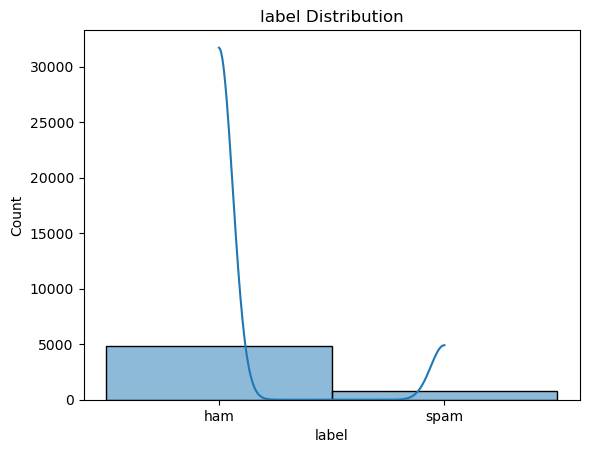

In [7]:
sns.histplot(df["label"], kde=True)
plt.title("label Distribution")
plt.show()

In [8]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(403)

In [10]:
df=df.drop_duplicates()

In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [13]:
df.shape

(5169, 2)

In [14]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Text Preprocessing

#### Text Preprocessing & Feature Engineering
- Clean text: lowercase, remove numbers, punctuation, stopwords, and stem words.
- Add statistical features: message length, number of digits, number of exclamation marks.

In [15]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_message'] = df['message'].apply(preprocess_text)

df['msg_length'] = df['message'].apply(len)
df['num_digits'] = df['message'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_exclam'] = df['message'].apply(lambda x: x.count('!'))

df['msg_length_bin'] = pd.cut(df['msg_length'], bins=10, labels=False)
df['num_digits_bin'] = pd.cut(df['num_digits'], bins=5, labels=False)
df['num_exclam_bin'] = pd.cut(df['num_exclam'], bins=5, labels=False)


## Feature Engineering (TF-IDF)

#### Feature Extraction
- Convert text to TF-IDF vectors with unigrams and bigrams.
- Standardize numerical features (length, digits, exclamation marks) using StandardScaler.

In [16]:
X = df[['clean_message','msg_length_bin','num_digits_bin','num_exclam_bin']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


preprocessor = ColumnTransformer([
    ('text', TfidfVectorizer(max_features=5000, ngram_range=(1,2)), 'clean_message'),
    ('num', 'passthrough', ['msg_length_bin','num_digits_bin','num_exclam_bin'])
])

In [17]:
X_train.shape

(4135, 4)

In [18]:
X_test.shape

(1034, 4)

## Model Training + Hyperparameter Tuning + Overfitting Checking

#### Model Training & Hyperparameter Tuning
- Train Multinomial Naive Bayes with different alpha values.
- Evaluate the best model using precision, recall, F1-score.
- Combines text (TF-IDF n-grams) and numerical features in a single pipeline.

In [19]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', MultinomialNB())
])

param_grid = {'clf__alpha':[0.1,0.5,1.0,2.0]}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    error_score='raise'
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred))

Best Parameters: {'clf__alpha': 0.1}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       903
           1       0.97      0.92      0.94       131

    accuracy                           0.99      1034
   macro avg       0.98      0.96      0.97      1034
weighted avg       0.99      0.99      0.99      1034



###  Cross-Validation Check for Overfitting

To ensure that our Naive Bayes model is not overfitting, we perform **5-fold cross-validation** on the training set using the F1-score as the evaluation metric.  

**What this shows:**
- Each fold gives an F1-score, indicating performance on unseen subsets of the training data.
- The mean F1-score across folds gives an overall estimate of model generalization.
- If the mean F1-score is close to the F1-score on the test set, it indicates that the model is **not overfitting**.

We will compute and display both the individual CV F1-scores and their mean.

In [20]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
print("CV F1 scores:", scores)
print("Mean F1:", scores.mean())

CV F1 scores: [0.90625    0.95049505 0.91836735 0.93203883 0.95609756]
Mean F1: 0.9326497584741584


## Save pipeline


In [21]:
joblib.dump(best_model, "spam_classifier.pkl")

['spam_classifier.pkl']